In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshansalian","key":"e39d75e6e585ec5470f827cdf8343728"}'}

In [3]:
!mkdir .kaggle
!cp /content/kaggle.json ~/.kaggle/
!kaggle datasets download -d dushyantv/consumer_complaints

mkdir: cannot create directory ‘.kaggle’: File exists
 98% 139M/142M [00:04<00:00, 32.8MB/s]
100% 142M/142M [00:05<00:00, 29.6MB/s]


In [4]:
!unzip consumer_complaints.zip

Archive:  consumer_complaints.zip
  inflating: Consumer_Complaints.csv  


In [0]:
import pandas as pd

data=pd.read_csv('Consumer_Complaints.csv')

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)
remove_n = 1000000
drop_indices = np.random.choice(data.index, remove_n, replace=False)
data = data.drop(drop_indices)
data.shape
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
10,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165,NaN
19,03-09-2016,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92703,NaN,NaN,Phone,03-09-2016,Closed with explanation,Yes,No,1823789,NaN
21,03/17/2017,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,WI,54005,NaN,NaN,Referral,03/20/2017,Closed with explanation,Yes,No,2393048,NaN
24,02/25/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"Navient Solutions, LLC.",RI,2906,NaN,NaN,Web,02/24/2014,Closed with explanation,Yes,Yes,730165,NaN
88,04/18/2017,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,NaN,NaN,JPMORGAN CHASE & CO.,MD,20772,NaN,NaN,Referral,04/19/2017,Closed with explanation,Yes,No,2439594,NaN


In [7]:
from io import StringIO
col = ['Product', 'Consumer Complaint']
data = data[col]
data = data[pd.notnull(data['Consumer Complaint'])]
data.columns = ['Product', 'Consumer_Complaint']
data['category_id'] = data['Product'].factorize()[0]
category_id_data = data[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_data.values)
id_to_category = dict(category_id_data[['category_id', 'Product']].values)
data.head()

,Product,Consumer_Complaint,category_id
947,Debt collection,Called XXXX verified they sent me a letter ver...,0
1009,Credit reporting,A original debt when into collections from XXX...,1
1209,Bank account or service,XX/XX/XXXX I received a confirmation of addres...,2
1244,Credit card,I received an application for the American Exp...,3
1268,Credit reporting,There is an account listed from XXXX XXXX XXXX...,1


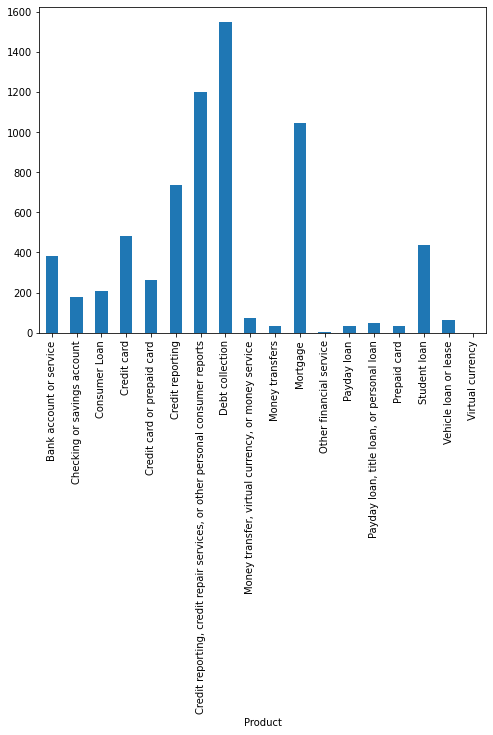

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.Consumer_Complaint).toarray()
labels = data.category_id
features.shape

(6769, 19329)

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("--> '{}':".format(Product))
  print("  . Most Correlated Unigrams are :\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most Correlated Bigrams are :\n. {}".format('\n. '.join(bigrams[-N:])))

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(data['Consumer_Complaint'], data['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

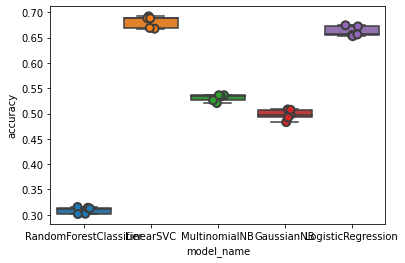

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GaussianNB                0.497709
LinearSVC                 0.681047
LogisticRegression        0.662135
MultinomialNB             0.530654
RandomForestClassifier    0.309055
Name: accuracy, dtype: float64

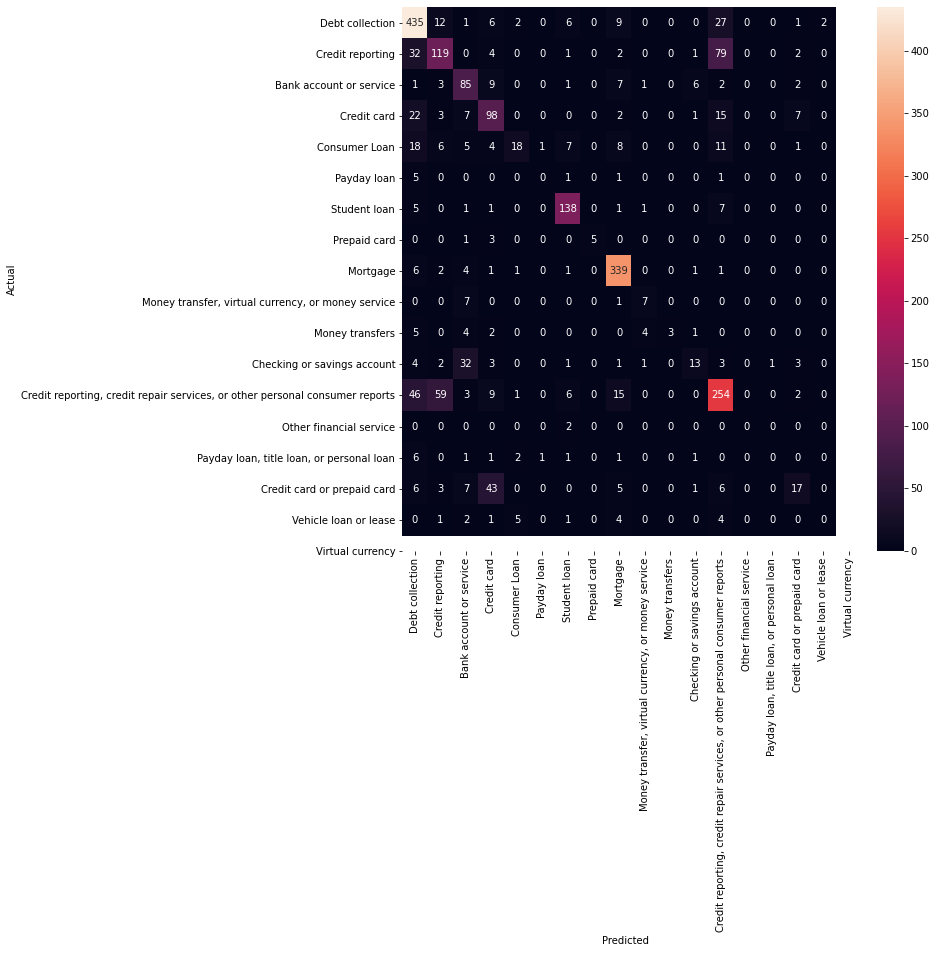

In [21]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_data.Product.values, yticklabels=category_id_data.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()